### 演習21）サンプルコードを実行し，フラグメントの確率的な組み換えを行い，所望のHOMO（highest occupied molecular orbital），LUMO（lowest unoccupied molecular orbital）を有する分子（有機薄膜太陽電池のドナー分子）を生成せよ．計算のフローについては，Algorithm3を参照せよ．

#### フラグメント組み換えによる仮想ライブラリの作製

ライブラリーの読み込み

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from xenonpy.descriptor import Fingerprints
from sklearn.ensemble import RandomForestRegressor as RF
from xenonpy.inverse.iqspr import NGram
from rdkit.Chem.EnumerateHeterocycles import EnumerateHeterocycles

フラグメントを結合させる関数、以下のプログラムの一部改変

https://github.com/yoshida-lab/XenonPy/blob/master/xenonpy/contrib/sample_codes/combine_fragments/combine_fragments.py

In [9]:
def GetCombSmiles(frag_base):
    smis_frag = frag_base[0]
    smis_base = frag_base[1]
    ngram = NGram()

    # check position of '*'
    mols_base = Chem.MolFromSmiles(smis_base)
    if mols_base is None:
        raise RuntimeError('Invalid base SMILES!')
    idx_base = [i for i in range(mols_base.GetNumAtoms()) if mols_base.GetAtomWithIdx(i).GetSymbol() == '*']
    
    # rearrange base SMILES to avoid 1st char = '*' (assume no '**')
    if len(idx_base) == 1 and idx_base[0] == 0:
        smis_base_head = Chem.MolToSmiles(mols_base,rootedAtAtom=1)
    elif len(idx_base) == 0:
        smis_base_head = smis_base + '*'
    else:
        smis_base_head = smis_base

    # converge base to ext. SMILES and pick insertion location
    esmi_base = ngram.smi2esmi(smis_base_head)
    esmi_base = esmi_base[:-1]
    idx_base = esmi_base.index[(esmi_base['esmi'] == '*') | (esmi_base['esmi'] == '[*]')].tolist()
    if len(idx_base) == 0:
        for w in ['-*' , '=*', '#*']:
            idx_base = esmi_base.index[esmi_base['esmi'] == w].tolist()
            if len(idx_base) > 0:
                break
    if idx_base[0] == 0:
        if len(idx_base) == 1:
            # put treatment here
            raise RuntimeError('Probably -*, =*, and/or #* exist')
        else:
            idx_base = idx_base[1]
    else:
        idx_base = idx_base[0]

    # rearrange fragment to have 1st char = '*' and convert to ext. SMILES
    mols_frag = Chem.MolFromSmiles(smis_frag)
    if mols_frag is None:
        raise RuntimeError('Invalid frag SMILES!')
    idx_frag = [i for i in range(mols_frag.GetNumAtoms()) if mols_frag.GetAtomWithIdx(i).GetSymbol() == '*']
    if len(idx_frag) == 0: # if -*, =*, and/or #* exist, not counted as * right now
        esmi_frag = ngram.smi2esmi(smis_frag)
        # remove last '!'
        esmi_frag = esmi_frag[:-1]
    else:
        esmi_frag = ngram.smi2esmi(Chem.MolToSmiles(mols_frag,rootedAtAtom=idx_frag[0]))
        # remove leading '*' and last '!'
        esmi_frag = esmi_frag[1:-1]

    # check open rings of base SMILES
    nRing_base = esmi_base['n_ring'].loc[idx_base]

    # re-number rings in fragment SMILES
    esmi_frag['n_ring'] = esmi_frag['n_ring'] + nRing_base

    # delete '*' at the insertion location
    esmi_base = esmi_base.drop(idx_base).reset_index(drop=True)

    # combine base with the fragment
    ext_smi = pd.concat([esmi_base.iloc[:idx_base], esmi_frag, esmi_base.iloc[idx_base:]]).reset_index(drop=True)
    new_pd_row = {'esmi': '!', 'n_br': 0, 'n_ring': 0, 'substr': ['!']}
    ext_smi.append(new_pd_row, ignore_index=True)

    fin_smi = ngram.esmi2smi(ext_smi)
    mol_fin = Chem.MolFromSmiles(fin_smi)
    if mol_fin is not None:
        can_sim_fin = Chem.MolToSmiles(mol_fin)
    else:
        can_sim_fin = None

    return can_sim_fin

アスタリスクを結合させる関数、演習20のInsertの一部改変

In [10]:
def ast_Insert(smi, max_iter=10):
    smiles = smi

    for j in range(max_iter):
        mol = Chem.MolFromSmiles(smiles)
        can = Chem.MolToSmiles(mol)
        pos = mol.GetNumAtoms() - 1
        if pos < 0:
            pos = 0
        idx = np.random.randint(0,pos)
        nsmi = Chem.MolToSmiles(mol,rootedAtAtom=idx)

        rsmi = '*' + nsmi

        if '**' in rsmi:
            continue

        mol_rsmi = Chem.MolFromSmiles(rsmi)
        if mol_rsmi is not None:
            fsmi = Chem.MolToSmiles(mol_rsmi)
            return fsmi

    return smiles

フラグメントの種類の組み合わせに従って、フラグメントを等確率でピックアップする関数

In [11]:
def creat_list(arr, list_list):
    rarr = []
    print(arr)
    for i in range(len(arr)):
        smi = np.random.choice(list_list[arr[i]])
        rsmi = ast_Insert(smi)
        rsmi = ast_Insert(rsmi)
        rarr.append(rsmi)

    return rarr

#### 1: Lopez et al. (2016) を参考に 7 個の構造を選定.

EnumerateHeterocyclesでの生成数を増やすために一部元素を置換しています。

In [12]:
smiles_list = []
smiles_list.append('c1ccccc1')
smiles_list.append('C1=CC=CN1')
smiles_list.append('C2=CC1=C(C=CC(=C1C=C2))')
smiles_list.append('C1(=C2C(=C(S1))C=CO2)')
smiles_list.append('C2=C(C1=CNC=C1C(=C2))')
smiles_list.append('C1=CC=C3C(=C1)C2=CC=CC=C2C4=C(NC(=C34))')
smiles_list.append('C23=C(C=C1C(=C(C(=C(C1=C2)))))C=CC=C3')

#### 2: 初期の7個からランダムに 2-5 個を選択し 100 個の組み合わせを作成する.

In [13]:
arr_list = []
for i in range(100):
    arr_list.append(np.random.choice(len(smiles_list), np.random.randint(2,6)))

#### 3: RDKit の rdkit.Chem.EnumerateHeterocycles というモジュールを用いて 7 個の構造に対して原子置換を施し 計5030 個のフラグメント集合を生成する.

In [14]:
fragment_list = []
for smi in smiles_list:
    this = []
    for smi_f in sorted(Chem.MolToSmiles(m) for m in EnumerateHeterocycles(Chem.MolFromSmiles(smi))):
        this.append(smi_f)

    fragment_list.append(this)
    

#### 4: 結合点を表すアスタリスク”*” をランダムに 2 個挿入し，各組のフラグメント同士を結合させ第 1 世代の 100 個の構造を生成する.

In [15]:
recipe = []
for arr in arr_list:
    recipe.append(creat_list(arr, fragment_list))

rsmi_list = []
for resi in recipe:
    rsmi = resi[0]
    for i in range(1, len(resi)):
        smiles = rsmi
        rsmi = GetCombSmiles([rsmi, resi[i]])
        if rsmi is None:
            rsmi = smiles

    rsmi = rsmi.replace('(*)','').replace('[*]','').replace('*','')

    if rsmi is not None and Chem.MolFromSmiles(rsmi):
        rsmi_list.append(rsmi)

[1 0 0]
[0 6 1]
[3 4]
[5 2 2 0 2]
[4 2]
[5 2 0 5 0]
[2 0 2]
[1 3 0 0 5]
[2 5 0 1]
[6 1]
[0 4]
[4 3 5 6]
[0 1 2 3]
[4 5 1 2]
[2 2 1 5]
[3 3 0 3 2]
[0 6 4 0 3]
[0 1]
[5 0 4 4 0]
[5 3 0 5]

RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4
RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4

RDKit ERROR: 
RDKit ERROR: [22:24:41] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [22:24:41] Explicit valence for atom # 1 O, 4, is greater than permitted
[22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4

[22:24:41] Explicit valence for atom # 1 O, 4, is greater than permitted
[22:24:41] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[22:24:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7

RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 


[5 4 6]
[5 4]
[5 1 5 2]
[3 3 1]
[1 6 1 3 1]
[3 3 2]
[6 5 1 4]
[0 3 2 1 3]
[5 4 0 0 6]
[3 5 0]
[6 3 1 5 2]
[0 2]
[3 2 0]
[6 5 2 3 2]


RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11 12 13 14 15 16 17
[22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11 12 13 14 15 16 17

RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17
RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 9 10 11 12 13 14 15 16 17 18
[22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 16 17

[22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 9 10 11 12 13 14 15 16 17 18

RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11 12 13 14 15 16 18
RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8
RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [22:24:41] Can't kekulize mol.  Unkekulized atoms: 2 3 6 8 9
[22:24:4

[0 0 0 0]
[2 1 0]
[5 1 6 3]
[3 5 0 1 3]
[6 4 0 1 3]
[1 3 1]
[5 6 6 2]
[2 4 2 6]
[4 0 0 5 5]
[6 6 4 2]
[4 4 1 3 6]
[1 2 6 5]
[3 6 0 1]
[5 3 6 3 4]


[22:24:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8

RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14

RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't keku

[3 5 5 5]
[2 5 4 0 0]
[0 3 5 2]
[0 3 3]
[5 2 5 6]
[4 4]
[1 4]
[6 4 0]
[5 5 2 3 0]
[5 2 3 5]


RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9
RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9
RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9
 6 7 8 9 10 11 13 14 15 16 18

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 13 14 15 16 18

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9

RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 7 9
RDKit ERRO

[3 6 3 5 0]
[4 5 2]
[2 4 6]
[0 0 2]
[1 1 0 6 1]
[2 3 4 6 3]
[4 6 6]
[4 3 5 1 2]
[2 3 4]
[6 3 4]
[3 6 3 5 3]
[1 6 1 6]
[0 1 5 0]
[0 0 5 0 0]
[5 1 0 4 0]


RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7

RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7
RDKit ERROR: 
[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7

RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 17
[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 17

RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8 9 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5
RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8 9 10 11 12 13 14 15 16 17 18

[22:24:42] Can't kekulize mol.  Unkekulized at

[6 5 4 4]
[2 1 4 0]
[0 4]
[0 1]
[1 3 3]
[0 0]
[1 2 5 4 4]
[6 6]
[4 5 4 4]
[2 6]
[3 0 6 5 4]
[5 6 5]
[1 0 3 0 1]
[1 4 6 1 3]
[0 4]
[5 2 2]
[5 5 1 6]


RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 5 6 8 9
[22:24:42] Explicit valence for atom # 1 N, 5, is greater than permitted
[22:24:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9

[22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 5 6 8 9

RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 9
RDKit ERROR: 
RDKit ERROR: [22:24:42] Explicit valence for atom # 1 O, 4, is greater than permitted
[22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 9

[22:24:42] Explicit valence for atom # 1 O, 4, is greater than permitted
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 9
RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 9
RDKit ERROR: 
RDKit ERROR: [22:24:42] Can't 

[0 1 5 1]
[6 1 3]
[6 2 3]
[1 4 1]
[2 4]
[3 4]
[3 6]
[6 0 5 5]
[5 6 2]
[6 6]


RDKit ERROR: [22:24:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2
[22:24:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2

RDKit ERROR: 
RDKit ERROR: [22:24:43] Explicit valence for atom # 7 C, 6, is greater than permitted
[22:24:43] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [22:24:43] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16
[22:24:43] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16

RDKit ERROR: 
RDKit ERROR: [22:24:43] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12
[22:24:43] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12

RDKit ERROR: 
RDKit ERROR: [22:24:43] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
RDKit ERROR: 
[22:24:43] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11

RDKit ERROR: [22:24:43] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
RDKit ERROR: 
[22:24:43] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15

RDKit ERROR: [22:24:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2
RDK

#### 5: 構造・物性のデータ集合でランダムフォレストのモデルを構築し，HOMO と LUMO の予測モデル YH = fH(S), YL = fL(S) を作成する.

データはあくまでも仮想分子の量子化学計算の結果を用いたサンプルデータです。
CEPなど適切なデータセットを利用することを推奨します。
また、本演習では予測精度の検討などは行なっておりません。
これらは別の演習をご参照ください。

In [18]:
data = pd.read_csv('data/Sample_data.csv')

FPs = Fingerprints(featurizers=['ECFP', 'MACCS'], input_type='smiles')
tmp_FPs = FPs.transform(data['SMILES'])

rg_HOMO = RF()
rg_HOMO.fit(tmp_FPs,data['HOMO(eV)'])

rg_LUMO = RF()
rg_LUMO.fit(tmp_FPs,data['LUMO(eV)'])


RandomForestRegressor()

#### 6: HOMO と LUMO の目標値を HOMO = −5.5 eV, LUMO = −4.0 eV とする.

In [19]:
target_HOMO = -5.5 
target_LUMO = -4.0
T = 50

#### 7: fort∈{1,...,T}do 以降の処理

In [20]:
for _ in range(T):
    for i in range(len(arr_list)):
        idx = np.random.randint(0, len(arr_list[i]))
        frag_type = arr_list[i][idx]

        # 構造改変用のフラグメント集合から F をランダムに選択する.
        new_frag  = np.random.choice(fragment_list[frag_type])
        rsmi = ast_Insert(new_frag)
        rsmi = ast_Insert(rsmi)
        
        # 選択されたフラグメントを F に置き換えて，Si′ を作成する.
        recipe[i][idx] = rsmi

    rsmi_list = []
    for resi in recipe:
        rsmi = resi[0]
        for i in range(1, len(resi)):
            smiles = rsmi
            #rsmi = combine_fragments.combine_fragments(rsmi, resi[i])
            rsmi = GetCombSmiles([rsmi, resi[i]])
            if rsmi is None:
                rsmi = smiles

        rsmi = rsmi.replace('(*)','').replace('[*]','').replace('*','')

        if rsmi is not None and Chem.MolFromSmiles(rsmi):
            rsmi_list.append(rsmi)

    # 適合度 wi = exp(−(YH∗ − fH (Si′ ))2 − (YL∗ − fL (Si′ ))2 ) を計算する.
    FPs_NewStrcture = FPs.transform(pd.Series(rsmi_list))        
    pred_homo = rg_HOMO.predict(FPs_NewStrcture)
    pred_lumo =  rg_LUMO.predict(FPs_NewStrcture)

    weight = np.exp(-(target_HOMO-pred_homo)**2-(target_LUMO-pred_lumo)**2)
    
    index_list = random.choices(range(100), k=100, weights=weight)

    arr_list_new = []
    recipe_new = []
    for idx in index_list:
        arr_list_new.append(arr_list[idx])
        recipe_new.append(recipe[idx])

    arr_list = arr_list_new.copy()
    recipe = recipe_new.copy()
    

RDKit ERROR: [22:30:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7
[22:30:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7

RDKit ERROR: 
RDKit ERROR: [22:30:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7
RDKit ERROR: 
RDKit ERROR: [22:30:56] Can't kekulize mol.  Unkekulized atoms: 2 4 6
[22:30:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7

[22:30:56] Can't kekulize mol.  Unkekulized atoms: 2 4 6

RDKit ERROR: 
RDKit ERROR: [22:30:56] Can't kekulize mol.  Unkekulized atoms: 2 3 5
RDKit ERROR: 
RDKit ERROR: [22:30:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8
[22:30:56] Can't kekulize mol.  Unkekulized atoms: 2 3 5

[22:30:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8

RDKit ERROR: 
RDKit ERROR: [22:30:56] Can't kekulize mol.  Unkekulized atoms: 3 5 7 8 9
[22:30:56] Can't kekulize mol.  Unkekulized atoms: 3 5 7 8 9

RDKit ERROR: 
RDKit ERROR: [22:30:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[22:30:56] Can't kekulize

/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_working/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


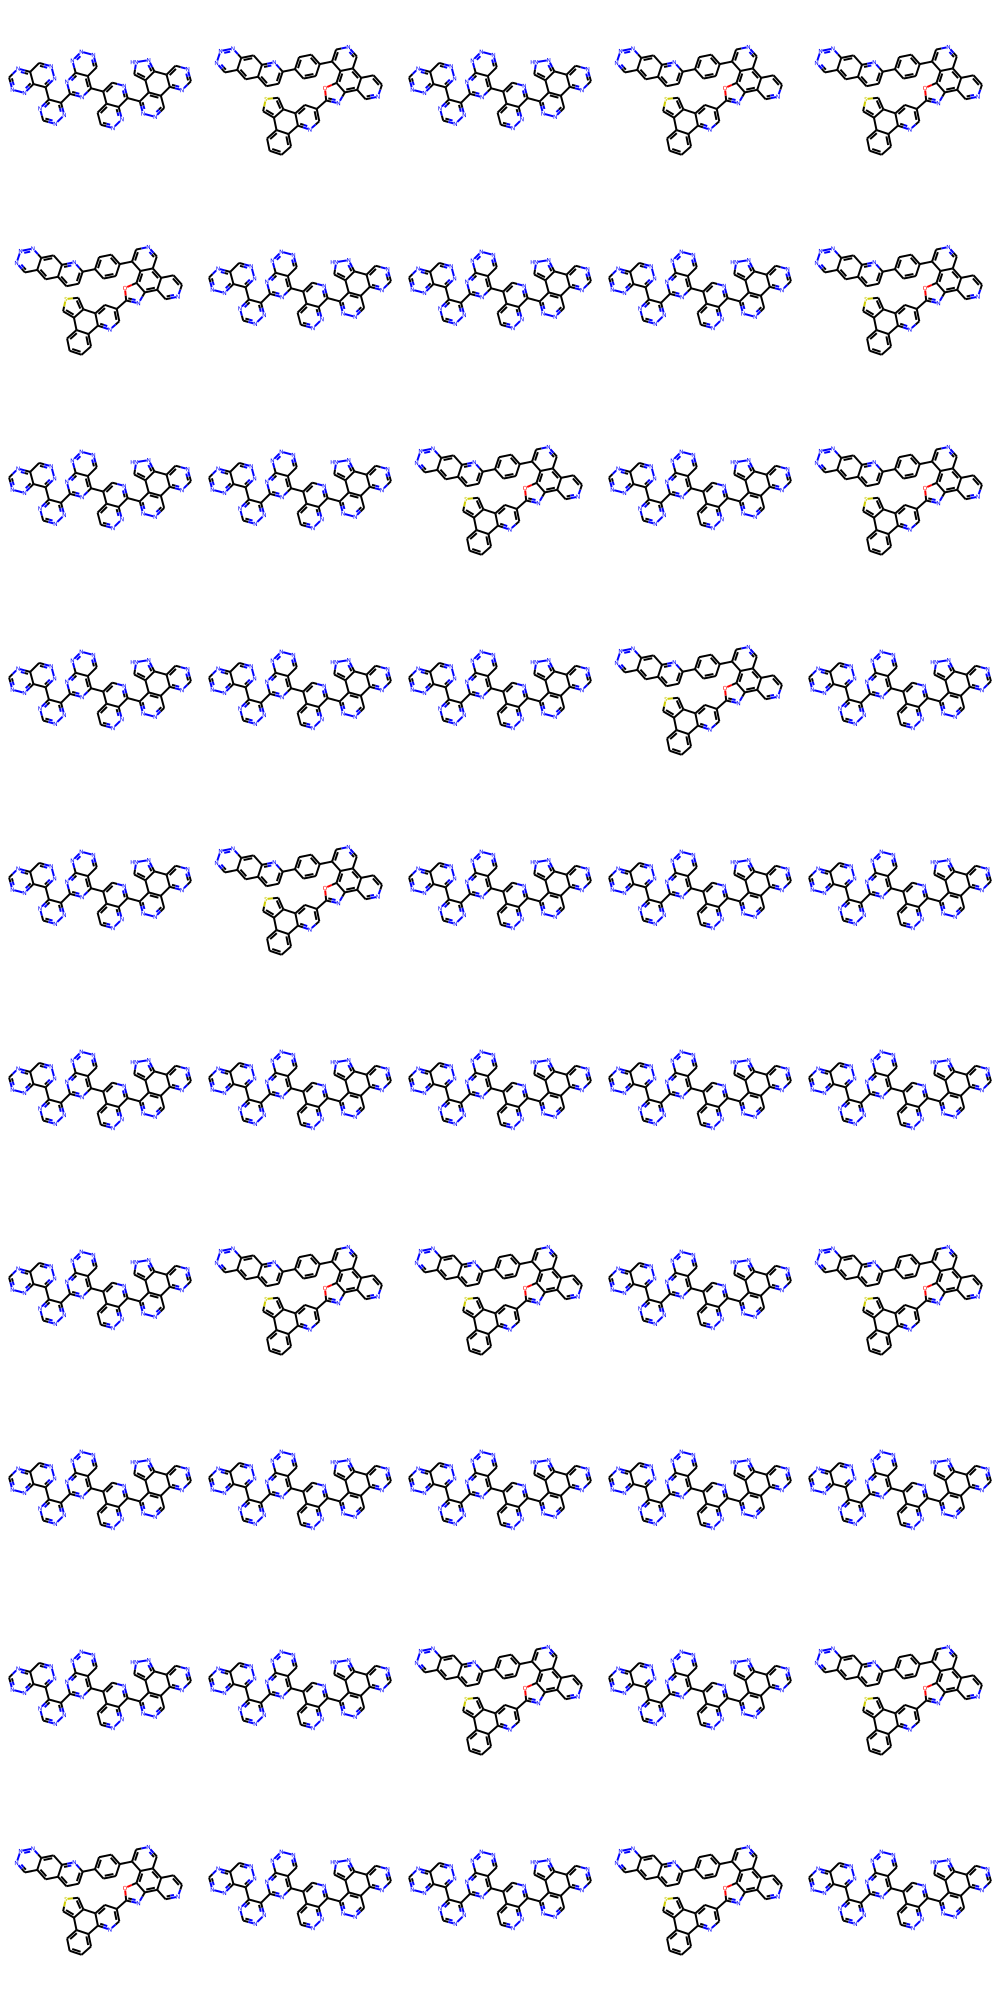

In [21]:
mols = []
for smi in rsmi_list:
    mols.append(Chem.MolFromSmiles(smi))
    
Draw.MolsToGridImage(mols,molsPerRow=5)
